In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score


In [2]:
df_train = pd.read_csv("steel.csv")

#training label
Y = df_train["tensile_strength"]

#training features
X = df_train[["normalising_temperature",
              "tempering_temperature",
              "percent_silicon",
              "percent_chromium",
              "percent_copper",
              "percent_nickel",
              "percent_sulphur",
              "percent_carbon",
              "percent_manganese"]]

MAE: 26.50
R² Score for each fold: [np.float64(0.8644), np.float64(0.7942), np.float64(0.7077), np.float64(0.8386), np.float64(0.7185), np.float64(0.7201), np.float64(0.8018), np.float64(0.6224), np.float64(0.867), np.float64(0.8525)]
Average R² across 10 folds: 0.78


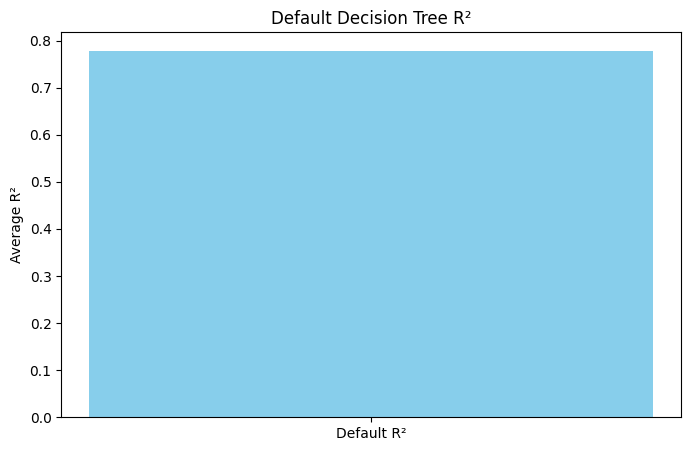

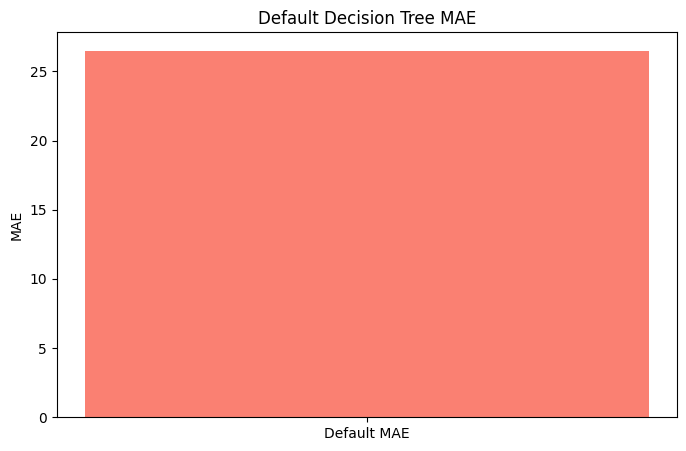

In [8]:
default_model = DecisionTreeRegressor(random_state=42)

#splitting data into 10 folds
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#predict value for each fold
y_pred = cross_val_predict(default_model, X, Y, cv=kf)

#measure average prediction error
mae = mean_absolute_error(Y, y_pred)

#measure how much variance can be explained
r2_scores = cross_val_score(default_model, X, Y, cv=kf, scoring='r2')
average_r2 = np.mean(r2_scores)

print(f"MAE: {mae:.2f}")
print(f"R² Score for each fold: {[round(score, 4) for score in r2_scores]}")
print(f"Average R² across {k} folds: {average_r2:.2f}")


plt.figure(figsize=(8,5))
plt.bar(["Default R²"], [average_r2], color=['skyblue'])
plt.ylabel("Average R²")
plt.title("Default Decision Tree R²")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(["Default MAE"], [mae], color=['salmon'])
plt.ylabel("MAE")
plt.title("Default Decision Tree MAE")
plt.show()


For min_samples_split=2, min_samples_leaf=1 → Train R²=1.00, Test R²=0.78, MAE=26.50
For min_samples_split=5, min_samples_leaf=1 → Train R²=0.99, Test R²=0.80, MAE=26.91
For min_samples_split=10, min_samples_leaf=1 → Train R²=0.95, Test R²=0.79, MAE=28.84
For min_samples_split=20, min_samples_leaf=1 → Train R²=0.91, Test R²=0.75, MAE=32.41
For min_samples_split=2, min_samples_leaf=2 → Train R²=0.98, Test R²=0.82, MAE=26.42
For min_samples_split=5, min_samples_leaf=2 → Train R²=0.98, Test R²=0.82, MAE=26.15
For min_samples_split=10, min_samples_leaf=2 → Train R²=0.95, Test R²=0.81, MAE=27.94
For min_samples_split=20, min_samples_leaf=2 → Train R²=0.90, Test R²=0.77, MAE=31.64
For min_samples_split=2, min_samples_leaf=4 → Train R²=0.95, Test R²=0.80, MAE=28.44
For min_samples_split=5, min_samples_leaf=4 → Train R²=0.95, Test R²=0.80, MAE=28.44
For min_samples_split=10, min_samples_leaf=4 → Train R²=0.94, Test R²=0.81, MAE=28.58
For min_samples_split=20, min_samples_leaf=4 → Train R²=0.90

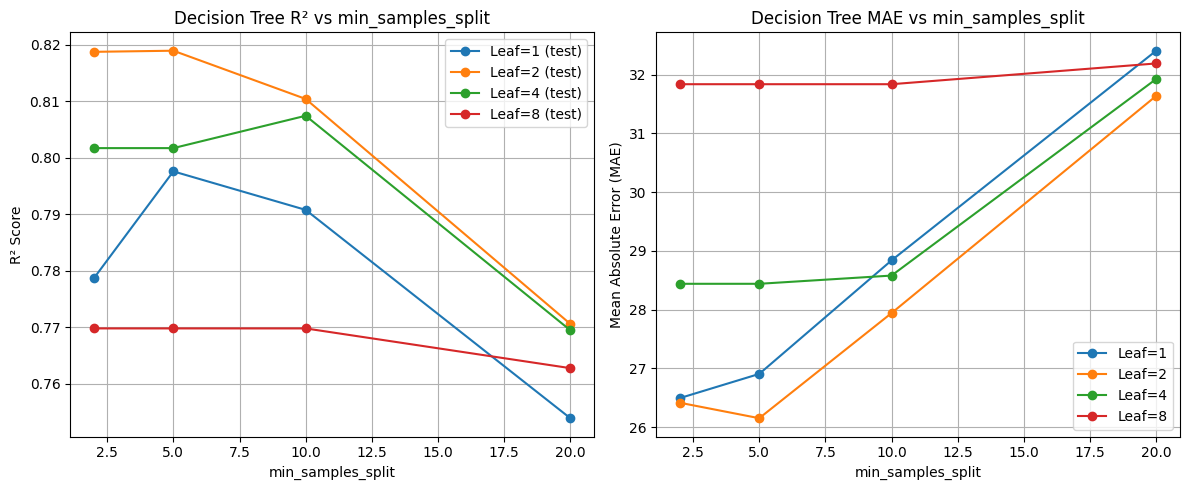

In [9]:
#hyperparameter values
min_samples_split_values = [2, 5, 10, 20]
min_samples_leaf_values = [1, 2, 4, 8]

#prepare results for plotting
results_r2_dt = {(split, leaf): {"train": 0, "test": 0} for split in min_samples_split_values for leaf in min_samples_leaf_values}
results_mae_dt = {(split, leaf): 0 for split in min_samples_split_values for leaf in min_samples_leaf_values}

kf = KFold(n_splits=k, shuffle=True, random_state=42)

param_grid = {
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values
}
#gridsearch to find best combination of models
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=kf,
    scoring='r2',
    return_train_score=True
)

grid_search.fit(X, Y)

#loop through all possible combinations and print results
cv_results = grid_search.cv_results_
for i in range(len(cv_results['params'])):
    min_split = cv_results['params'][i]['min_samples_split']
    min_leaf = cv_results['params'][i]['min_samples_leaf']
    mean_train_r2 = cv_results['mean_train_score'][i]
    mean_test_r2 = cv_results['mean_test_score'][i]
    
    model = DecisionTreeRegressor(min_samples_split=min_split, 
                                  min_samples_leaf=min_leaf, 
                                  random_state=42)
    y_pred = cross_val_predict(model, X, Y, cv=kf)
    mae = mean_absolute_error(Y, y_pred)
    
    results_r2_dt[(min_split, min_leaf)]["train"] = mean_train_r2
    results_r2_dt[(min_split, min_leaf)]["test"] = mean_test_r2
    results_mae_dt[(min_split, min_leaf)] = mae
    
    print(f"For min_samples_split={min_split}, min_samples_leaf={min_leaf} "f"Train R²={mean_train_r2:.2f}, Test R²={mean_test_r2:.2f}, MAE={mae:.2f}")

print("\nBest hyperparameters based on R²:", grid_search.best_params_)

plt.figure(figsize=(12,5))

#R² graph
plt.subplot(1,2,1)
for leaf in min_samples_leaf_values:
    test_vals = [results_r2_dt[(split, leaf)]["test"] for split in min_samples_split_values]
    plt.plot(min_samples_split_values, test_vals, marker='o', label=f"Leaf={leaf} (test)")
plt.xlabel("min_samples_split")
plt.ylabel("R² Score")
plt.title("Decision Tree R² vs min_samples_split")
plt.legend()
plt.grid(True)

#MAE graph
plt.subplot(1,2,2)
for leaf in min_samples_leaf_values:
    mae_vals = [results_mae_dt[(split, leaf)] for split in min_samples_split_values]
    plt.plot(min_samples_split_values, mae_vals, marker='o', label=f"Leaf={leaf}")
plt.xlabel("min_samples_split")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Decision Tree MAE vs min_samples_split")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
